Notebook originally by [@alekseynp](https://gist.github.com/alekseynp/41f70c509176cbff765e79ebe5edaa6a)

This notebooks illustrates how multiple ReLU hidden neurons can model a 1D nonlinear function when being stacked together

In [1]:
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mlp
mlp.style.use('classic')

In [2]:
from keras.models import Model
from keras.layers import Input, Dense
import keras.optimizers

Using Theano backend.


In [27]:
def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def activate(x):
    return sigmoid(x)

In [3]:
def get_model(num_hidden_units):
    model_input = Input(shape=(1,), dtype='float32', name='input')
    net = Dense(num_hidden_units, activation='relu')(model_input)
    out = Dense(1, activation='linear')(net)

    model = Model(inputs=model_input, outputs=out)
    optimizer = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=optimizer)    
    return model

In [4]:
def poly_generator(coeffs, batch_size=320):
    output_x = np.zeros((batch_size))
    output_y = np.zeros((batch_size))
       
    while True:
        output_x = np.random.uniform(-1.0, 1.0, batch_size)
        output_y = np.polynomial.polynomial.polyval(output_x, coeffs)
        yield output_x, output_y

In [5]:
def train_a_model(num_hidden_units, coeffs):
    model = get_model(num_hidden_units)
    generator = poly_generator(coeffs)
    model.fit_generator(generator, steps_per_epoch=5000, epochs=1, verbose=0)
    return model

In [6]:
def train_models(coeffs):
    models = []
    for num_hidden_units in np.arange(1, 10):
        print('{0}'.format(num_hidden_units), end=', ')
        mod = train_a_model(num_hidden_units, coeffs)
        models.append(mod)
    return models

In [7]:
def get_num_hidden_units(model):
    return model.layers[1].get_config()['units']

def plot_a_model(ax, model, coeffs):
    xs = np.arange(-1.0,1.0,0.01)
    ys = model.predict(xs).ravel()
    ys_true = np.polynomial.polynomial.polyval(xs, coeffs)

    ax.plot(xs, ys, label='Preds')
    ax.plot(xs, ys_true, label='Truth')

    # trying to highlight the kinks, maybe off by 1 or 2 positions, but that's fine
    delta = np.abs(ys[1:] - ys[:-1])
    ddelta = np.abs(delta[1:] - delta[:-1])
    num = get_num_hidden_units(model)
    idxes = np.argsort(ddelta)[-num:]
    ax.plot(xs[idxes], ys[idxes], 'o')

def plot_models(models, coeffs):
    assert len(models) == 9
    fig, axarr = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 10))

    for i, ax in enumerate(np.ravel(axarr)):
        print('{0}'.format(i + 1), end=', ')
        mod = models[i]
        num = get_num_hidden_units(mod)
        plot_a_model(ax, mod, coeffs)
        ax.set_title('# hidden units: {}'.format(num))
    plt.tight_layout()

# Experiments

### Experiment 1 
Target function:
$$f(x) = 0.1 + 0.2x + 0.3x^2 + 0.4x^3$$

Model:
- Single layer neural network with between 1 and 9 hidden units

In [8]:
coeffs = [0.1, 0.2, 0.3, 0.4]

In [9]:
%time models = train_models(coeffs)

1, 2, 3, 4, 5, 6, 7, 8, 9, CPU times: user 55 s, sys: 680 ms, total: 55.7 s
Wall time: 3min 47s


1, 2, 3, 4, 5, 6, 7, 8, 9, 

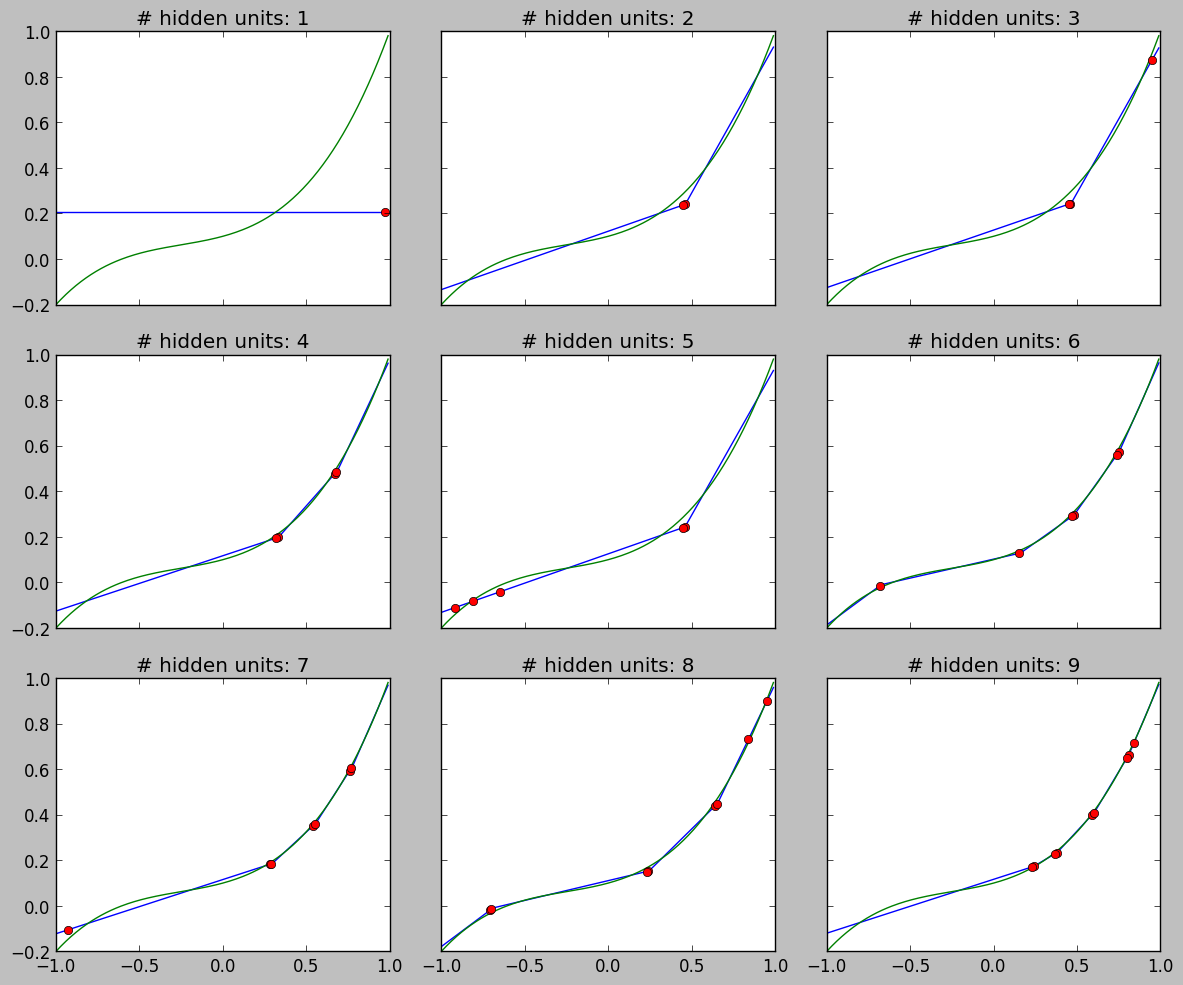

In [10]:
plot_models(models, coeffs)

circles highlight where the kinks are, it looks as the number of hidden neurons grow, the number of kinks increases, too, which hints a stacking effect of the ReLU hidden neurons.

### Experiment 2
Target function:
$$f(x) = x^2$$ 

Model:
- Single layer neural network with between 1 and 9 hidden units

In [11]:
coeffs = [0, 0, 1]

In [12]:
%time models = train_models(coeffs)

1, 2, 3, 4, 5, 6, 7, 8, 9, CPU times: user 55.2 s, sys: 731 ms, total: 56 s
Wall time: 3min 44s


1, 2, 3, 4, 5, 6, 7, 8, 9, 

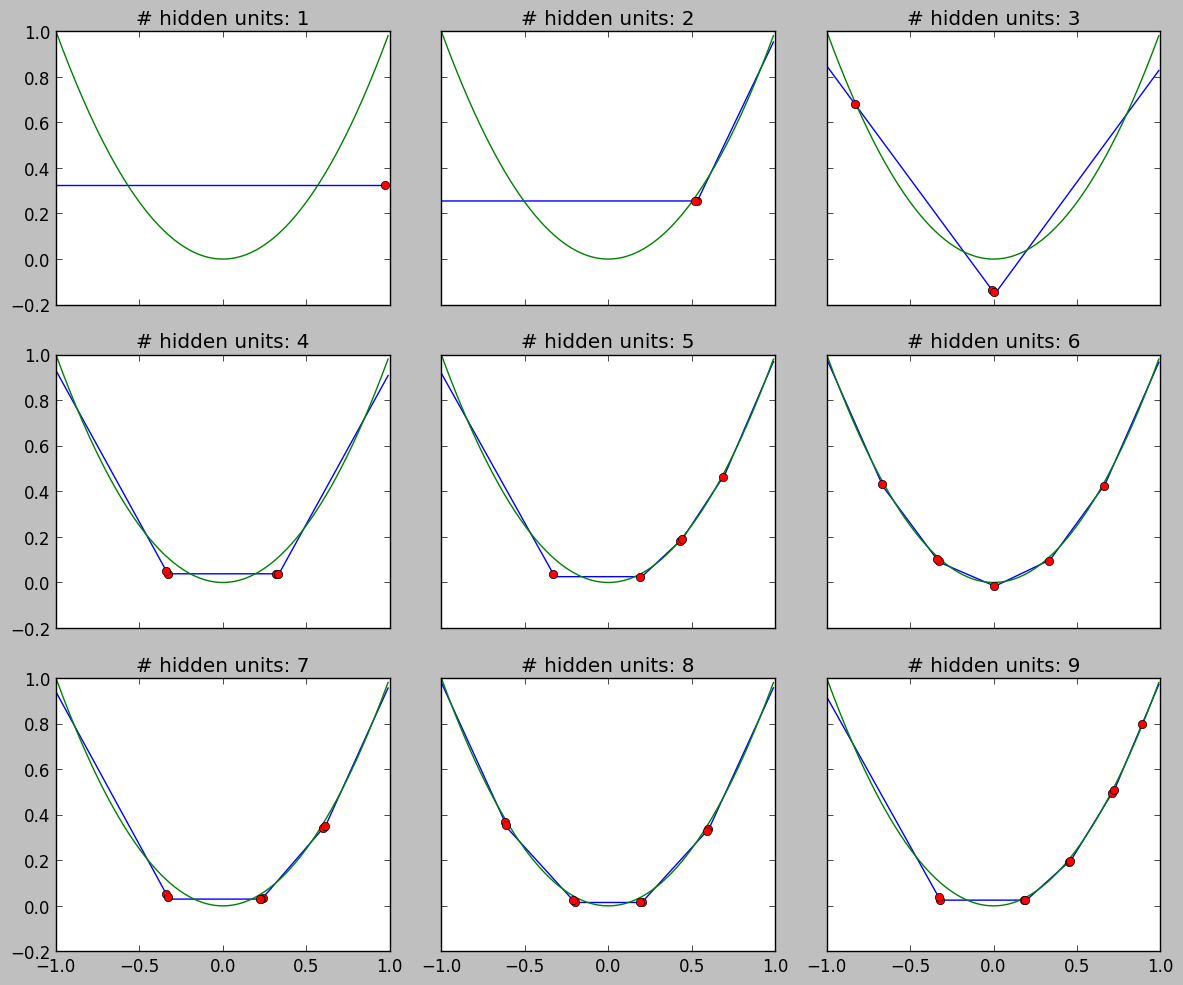

In [13]:
plot_models(models, coeffs)

### Experiment 3
Target function:
$$f(x) = 0.1 + 0.2x + 0.3x^2 + 0.4x^3 + 0.5x^4$$ 

Model:
- Single layer neural network with between 1 and 9 hidden units

In [14]:
coeffs = [0.1, 0.2, 0.3, 0.4, 0.5]

In [15]:
%time models = train_models(coeffs)

1, 2, 3, 4, 5, 6, 7, 8, 9, CPU times: user 55.8 s, sys: 812 ms, total: 56.6 s
Wall time: 3min 46s


1, 2, 3, 4, 5, 6, 7, 8, 9, 

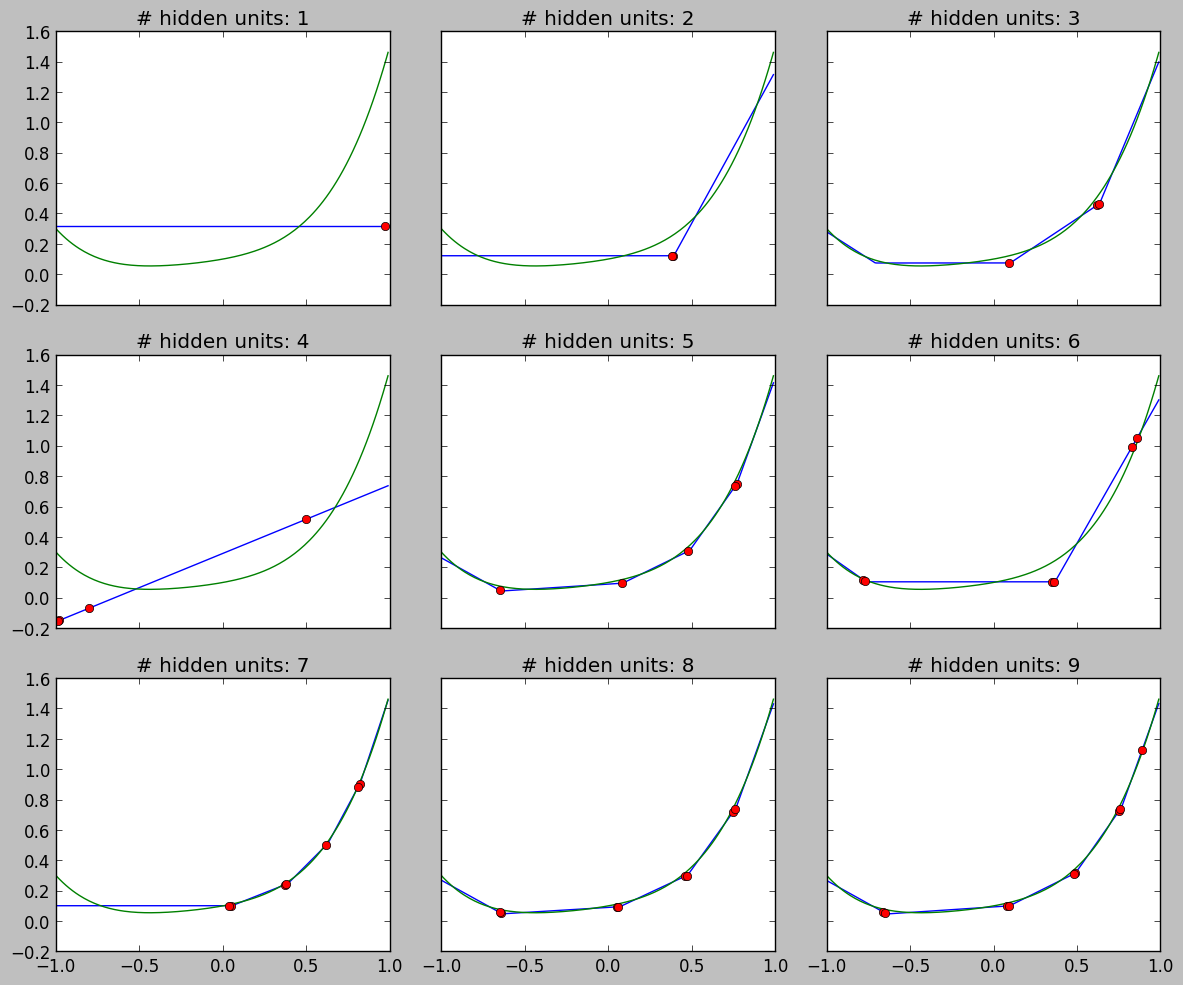

In [16]:
plot_models(models, coeffs)

# Dig a little deeper
$$f(x) = 0.1 + 0.2x + 0.3x^2 + 0.4x^3$$

In [17]:
coeffs = [0.1, 0.2, 0.3, 0.4]
num_hidden_units = 8
model = train_a_model(num_hidden_units, coeffs)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1)                 0         
_________________________________________________________________
dense_55 (Dense)             (None, 8)                 16        
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 9         
Total params: 25.0
Trainable params: 25.0
Non-trainable params: 0.0
_________________________________________________________________


In [18]:
model.get_weights()

[array([[-0.79139167, -0.65163743, -0.71587455,  1.14681256, -0.02786206,
         -0.06411327,  0.12432803,  0.46973059]], dtype=float32),
 array([ 0.19502412,  0.65130079, -0.49174944, -0.75377989, -0.13087074,
        -0.17626916, -0.23834538,  0.46865439], dtype=float32),
 array([[ 0.68741024],
        [-0.67154795],
        [-0.525594  ],
        [ 0.69911903],
        [-0.50638217],
        [-0.05023671],
        [-0.41248125],
        [ 0.60911667]], dtype=float32),
 array([ 0.12600525], dtype=float32)]

In [19]:
# train another model to illustrate local minima
model2 = train_a_model(num_hidden_units, coeffs)

### Plot target f(x) vs. neural network.

In [20]:
hidden_weights = model.layers[1].get_weights()
output_weights = model.layers[2].get_weights()

In [21]:
hidden_weights

[array([[-0.79139167, -0.65163743, -0.71587455,  1.14681256, -0.02786206,
         -0.06411327,  0.12432803,  0.46973059]], dtype=float32),
 array([ 0.19502412,  0.65130079, -0.49174944, -0.75377989, -0.13087074,
        -0.17626916, -0.23834538,  0.46865439], dtype=float32)]

In [22]:
output_weights

[array([[ 0.68741024],
        [-0.67154795],
        [-0.525594  ],
        [ 0.69911903],
        [-0.50638217],
        [-0.05023671],
        [-0.41248125],
        [ 0.60911667]], dtype=float32), array([ 0.12600525], dtype=float32)]

# Show each neuron ReLU output before and after weighted by output layer weights together

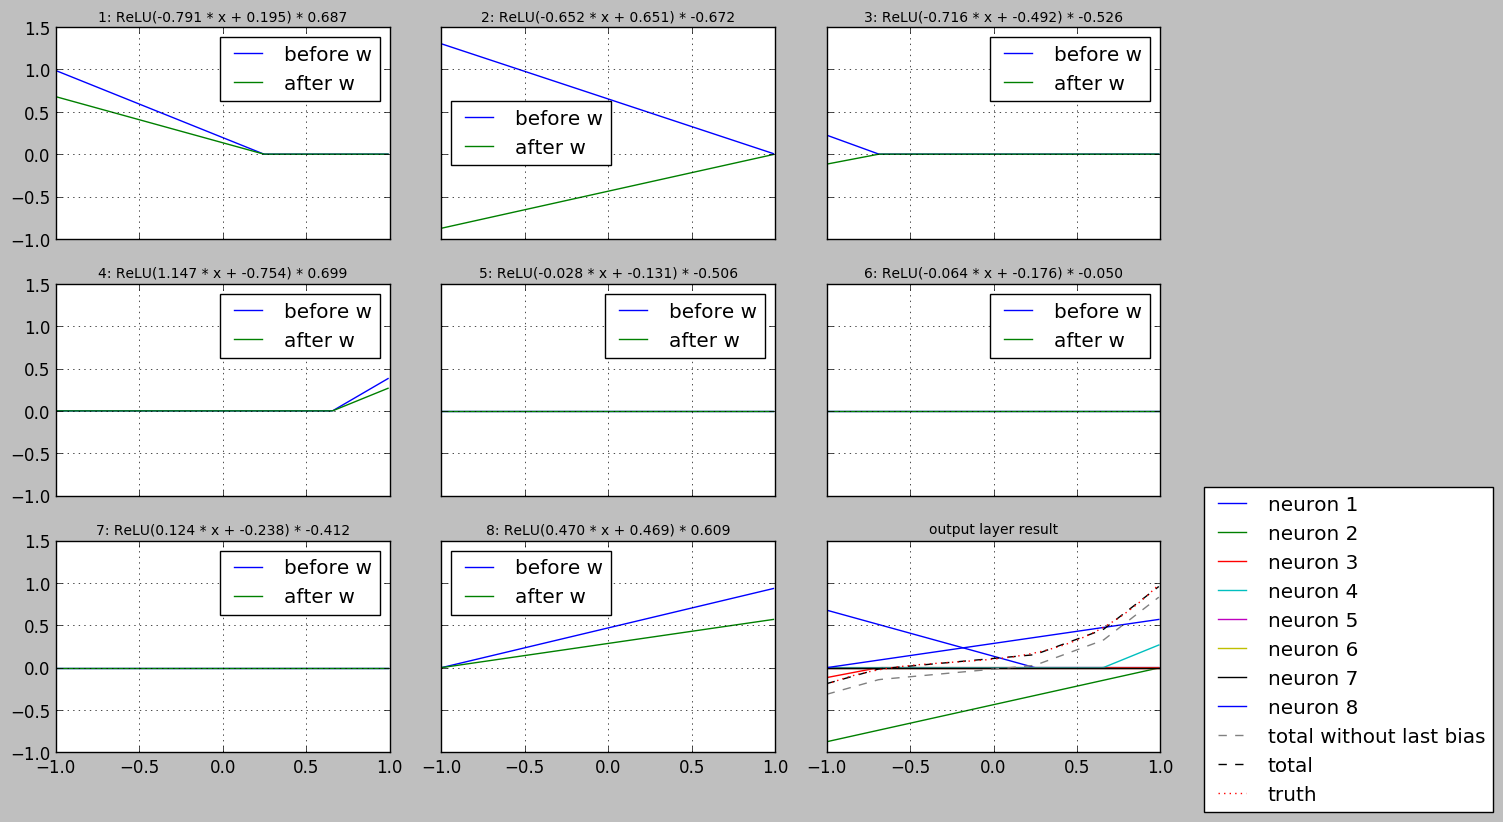

In [30]:
fig, axarr = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 8))
axarr = axarr.ravel()
last_ax = axarr[-1]

xs = np.arange(-1.0, 1.0, 0.01)
relu_total = 0
relu_total_no_bias = 0
for i, ax in enumerate(axarr):
    if i >= num_hidden_units:
        continue
    hidden_w = float(hidden_weights[0][0][i])
    hidden_b = float(hidden_weights[1][i])

    output_w = output_weights[0][i][0]
    before = relu(hidden_w * xs + hidden_b) 
    after = before * output_w
    
    ax.plot(xs, before, label='before w')
    ax.plot(xs, after, label='after w')
    
    last_ax.plot(xs, after, label='neuron {0}'.format(i + 1))
    ax.set_title('{0}: ReLU({1:.3f} * x + {2:.3f}) * {3:.3f}'.format(i + 1, hidden_w, hidden_b, output_w),
                 fontsize=10)
    ax.grid()
    ax.legend(loc='best')

    relu_total += after

relu_total_no_bias = relu_total.copy()
output_b = output_weights[1][0]
relu_total += output_b

last_ax.plot(xs, relu_total_no_bias, '--', color='gray', label='total without last bias')
last_ax.plot(xs, relu_total, '--', color='black', label='total')

ys_true = np.polynomial.polynomial.polyval(xs, coeffs)
last_ax.plot(xs, ys_true, ':', color='red', label='truth')
last_ax.grid()
last_ax.set_title('output layer result', fontsize=10)
last_ax.legend(loc="upper left", bbox_to_anchor=(1.1,1.3))

plt.tight_layout()

So weights and biases (from both 2nd and last layers) just change the slope and kink position of ReLUs. When they are all stacked together and summed up, interesting nonlinearity happens. A few neurons could be dead (useless) some times.

# Illustrate the stacking effects of relu one by one

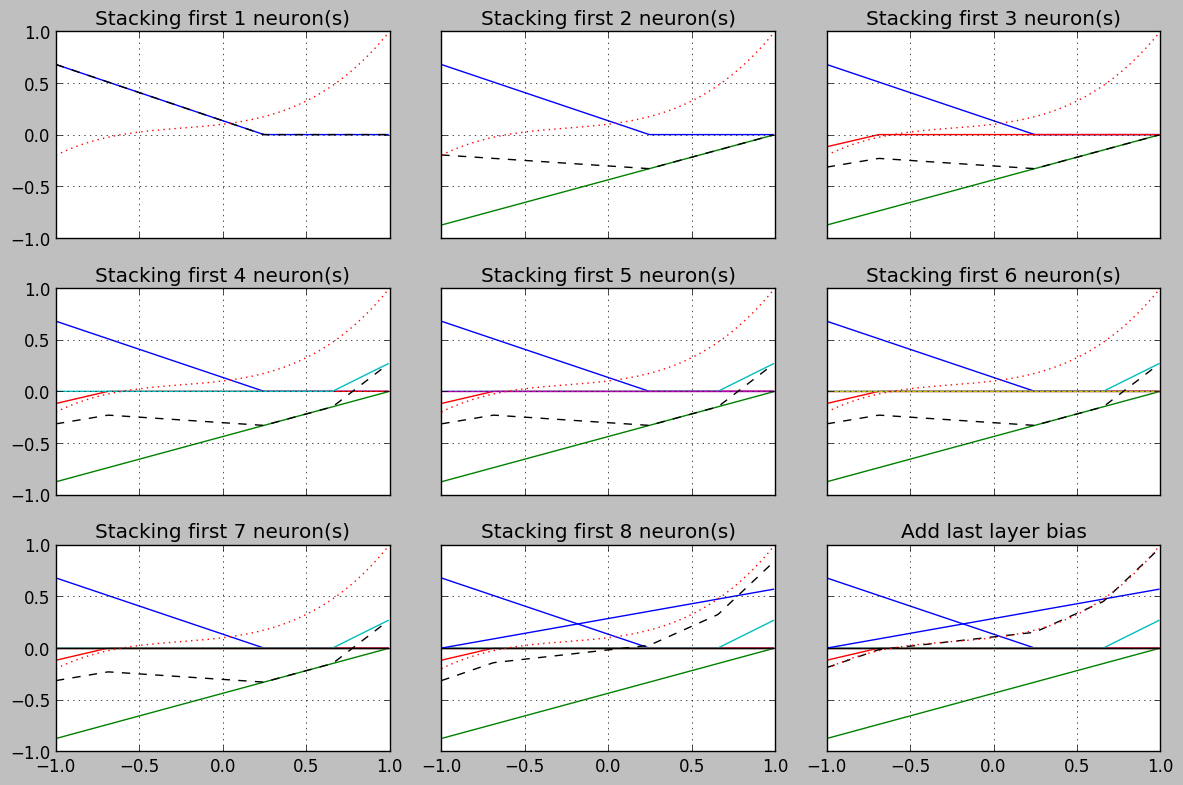

In [31]:
fig, axarr = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 8))
axarr = axarr.ravel()
last_ax = axarr[-1]

xs = np.arange(-1.0, 1.0, 0.01)
ys_true = np.polynomial.polynomial.polyval(xs, coeffs)
relu_total = 0
relus = []
for i, ax in enumerate(axarr):
    if i >= num_hidden_units:
        continue
    hidden_w = float(hidden_weights[0][0][i])
    hidden_b = float(hidden_weights[1][i])

    output_w = output_weights[0][i][0]
    vals = relu(hidden_w * xs + hidden_b) * output_w
    relus.append((xs, vals))

    for _x, _y in relus:
        ax.plot(_x, _y)
    relu_total += vals   

    ax.plot(xs, relu_total, '--', color='black', label='total')
    ax.plot(xs, ys_true, ':', color='red', label='truth')
    ax.grid()
    ax.set_title('Stacking first {0} neuron(s)'.format(i + 1))

for _x, _y in relus:
    last_ax.plot(_x, _y)
output_b = output_weights[1][0]
relu_total += output_b
last_ax.plot(xs, relu_total, '--', color='black', label='total')
last_ax.plot(xs, ys_true, ':', color='red', label='truth')
last_ax.set_title('Add last layer bias')
last_ax.grid()

plt.tight_layout()

# Illustrate difference/similarity between two trained models

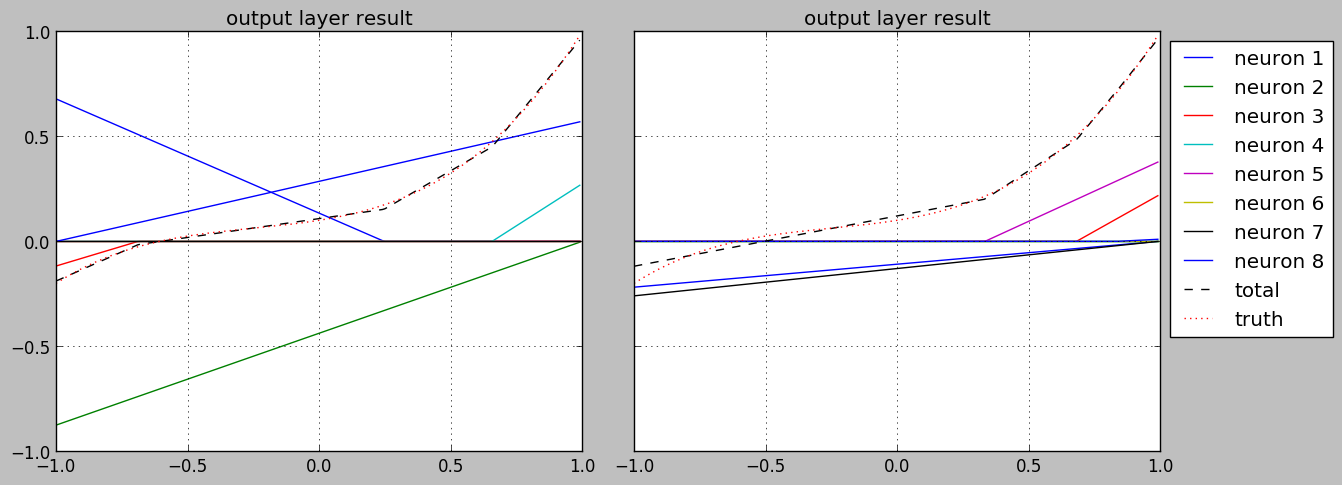

In [32]:
fig, axarr = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 5))
axarr = axarr.ravel()

xs = np.arange(-1.0, 1.0, 0.01)
for k, (ax, mod) in enumerate(zip(axarr, [model, model2])):
    relu_total = 0
    num_hu = get_num_hidden_units(mod)
    hidden_weights = mod.layers[1].get_weights()
    output_weights = mod.layers[2].get_weights()
    for i in range(num_hu):
        hidden_w = hidden_weights[0][0][i]
        hidden_b = hidden_weights[1][i]

        output_w = output_weights[0][i][0]
        vals = relu(hidden_w * xs + hidden_b) * output_w
        ax.plot(xs, vals, label='neuron {0}'.format(i + 1))
        relu_total += vals
    
    # There is only a single output bias value as there is only a single output neuron
    output_b = output_weights[1][0]
    relu_total += output_b

    ax.plot(xs, relu_total, '--', color='black', label='total')
    ys_true = np.polynomial.polynomial.polyval(xs, coeffs)
    ax.plot(xs, ys_true, ':', color='red', label='truth')
    ax.grid()
    ax.set_title('output layer result')
    if k == 1:
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()

Seems the first model hits a worse local minimum.

#### So

1. At least in 1D, nonlinear functions can be approximated by stacking weighted relu outputs given enough hidden neurons.

1. Kinks are results of overlapping 9 plots, assuming each line has one kink (i.e. non-linearity of ReLU).

1. Repeating the experiments may produce hidden neurons with different weights and bias while their linear combination results in similar shape, which explains why multiple different NNs have similar performances (local minima!).

# Try another function

An interesting experiment above that might be simple enough to gain some inuition is the 4 neuron network attempting to fit $$f(x) = x^2$$

In [33]:
coeffs = [0, 0, 1]
num_hidden_units = 8
model = train_a_model(num_hidden_units, coeffs)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1)                 0         
_________________________________________________________________
dense_59 (Dense)             (None, 8)                 16        
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 9         
Total params: 25.0
Trainable params: 25.0
Non-trainable params: 0.0
_________________________________________________________________


### Plot target f(x) vs. neural network.

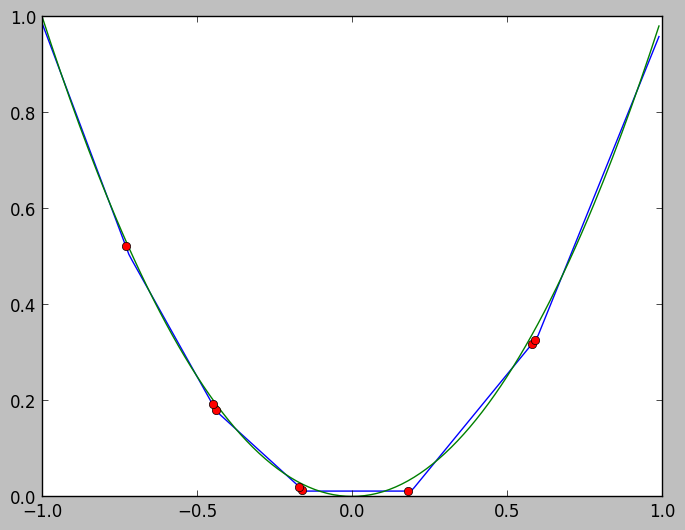

In [34]:
fig = plt.figure()
ax = plt.gca()
plot_a_model(ax, model, coeffs)

In [35]:
hidden_weights = model.layers[1].get_weights()
output_weights = model.layers[2].get_weights()

In [36]:
hidden_weights

[array([[ 0.26544872,  0.25176525, -0.97152573,  0.60701871,  1.15412557,
         -0.06937189, -0.80540317, -0.66474795]], dtype=float32),
 array([-0.2828716 , -0.26002869, -0.69845313, -0.36261287, -0.22070035,
        -0.20083743, -0.12493   , -0.29049128], dtype=float32)]

In [42]:
output_weights

[array([[-0.5524255 ],
        [-0.17217201],
        [ 0.58253336],
        [ 1.33348131],
        [ 0.68236136],
        [-0.30433348],
        [ 0.73039645],
        [ 0.85238963]], dtype=float32), array([ 0.01117314], dtype=float32)]

## Each suplot shows output from hidden ReLU

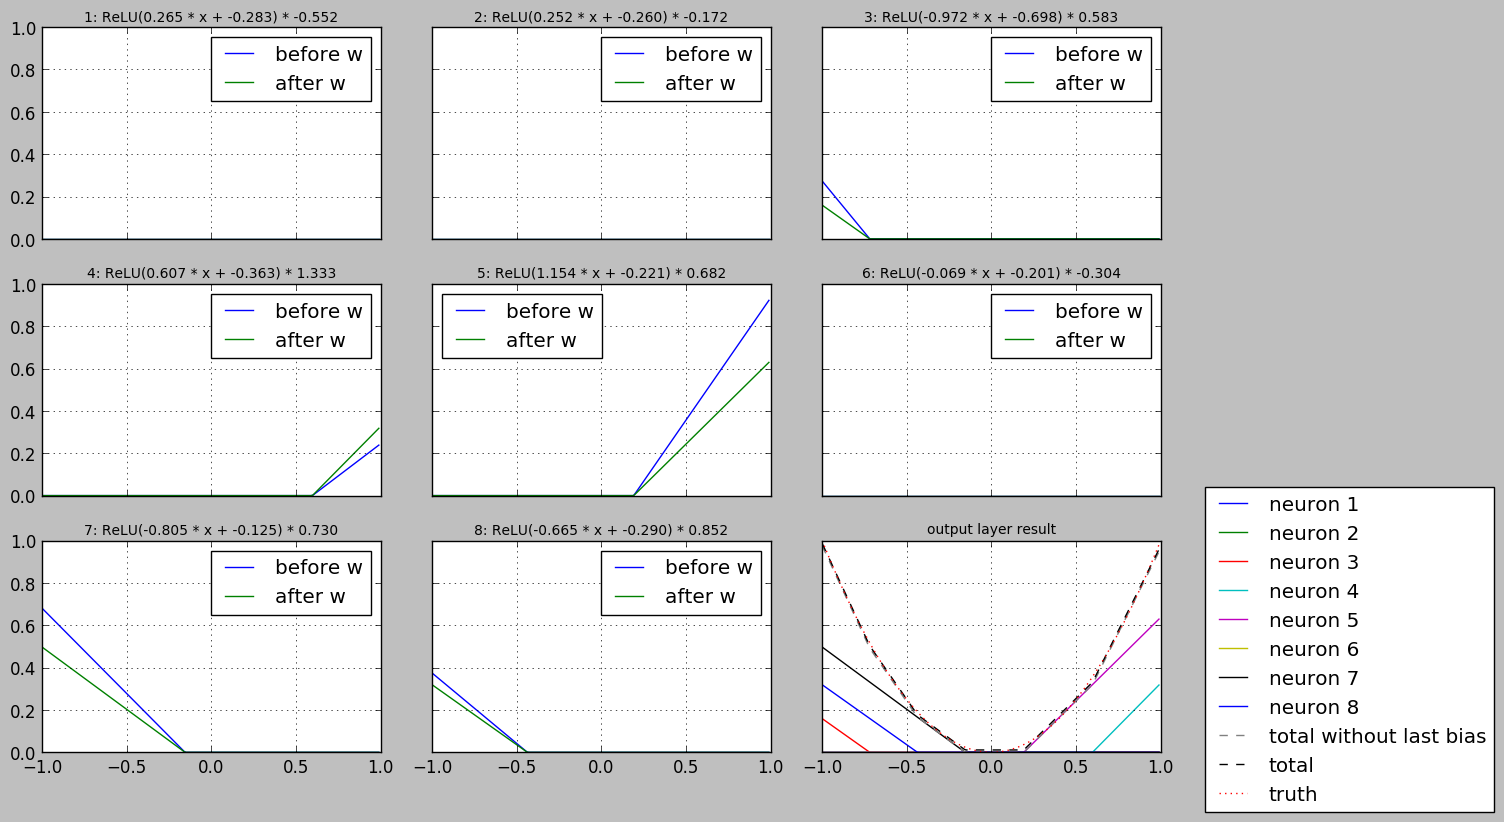

In [41]:
fig, axarr = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 8))
axarr = axarr.ravel()
last_ax = axarr[-1]

xs = np.arange(-1.0, 1.0, 0.01)
relu_total = 0
relu_total_no_bias = 0
for i, ax in enumerate(axarr):
    if i >= num_hidden_units:
        continue
    hidden_w = float(hidden_weights[0][0][i])
    hidden_b = float(hidden_weights[1][i])

    output_w = output_weights[0][i][0]
    before = relu(hidden_w * xs + hidden_b) 
    after = before * output_w
    
    ax.plot(xs, before, label='before w')
    ax.plot(xs, after, label='after w')
    
    last_ax.plot(xs, after, label='neuron {0}'.format(i + 1))
    ax.set_title('{0}: ReLU({1:.3f} * x + {2:.3f}) * {3:.3f}'.format(i + 1, hidden_w, hidden_b, output_w),
                 fontsize=10)
    ax.grid()
    ax.legend(loc='best')

    relu_total += after

relu_total_no_bias = relu_total.copy()
output_b = output_weights[1][0]
relu_total += output_b

last_ax.plot(xs, relu_total_no_bias, '--', color='gray', label='total without last bias')
last_ax.plot(xs, relu_total, '--', color='black', label='total')

ys_true = np.polynomial.polynomial.polyval(xs, coeffs)
last_ax.plot(xs, ys_true, ':', color='red', label='truth')
last_ax.grid()
last_ax.set_title('output layer result', fontsize=10)
last_ax.legend(loc="upper left", bbox_to_anchor=(1.1,1.3))

plt.tight_layout()

# Try a more complex function from http://neuralnetworksanddeeplearning.com/chap4.html (todo)

$$f(x) = 0.2 + 0.4 x^2 + 0.3 sin(15x) + 0.05 cos(50x)$$

In [4]:
def cust_generator(coeffs, batch_size=320):
    output_x = np.zeros((batch_size))
    output_y = np.zeros((batch_size))
       
    while True:
        output_x = np.random.uniform(-1.0, 1.0, batch_size)
        output_y = np.polynomial.polynomial.polyval(output_x, coeffs)
        yield output_x, output_y

In [5]:
def train_a_model(num_hidden_units, coeffs):
    model = get_model(num_hidden_units)
    generator = poly_generator(coeffs)
    model.fit_generator(generator, steps_per_epoch=1000, epochs=1, verbose=0)
    return model

In [ ]:
def train_a_model(num_hidden_units, coeffs):
    model = get_model(num_hidden_units)
    generator = poly_generator(coeffs)
    model.fit_generator(generator, steps_per_epoch=1000, epochs=1, verbose=0)
    return model